In [14]:
import harmony as harm
import twopoint
import castor as ca
from functools import partial
import seaborn as sns
import healpy as hp
import numpy as np
import os, sys
import pickle
from tqdm.auto import trange, tqdm

data_dir = '/global/cfs/cdirs/des/xuod/DES_Y3_shear_analysis/data/Y3_mastercat_12_3_19_v2'
root_dir = '/global/cfs/cdirs/des/xuod/DES_Y3_shear_analysis/'

_nside_h = 1024
nside = 1024
lmin = 2
lmax = 2*_nside_h
b_lmax = 3*nside-1
n_ell_bins = 32

bin_func = partial(ca.maths.powspace, power=0.5)
# bins_ell = bin_func(2, 2*1024, 32)[:10]

b = harm.utils.make_nmtbin(_nside_h, lmin, lmax, n_ell_bins, bin_func=bin_func,
                             f_ell='pixwin', verbose=True, b_lmax=b_lmax)

config = harm.Config(name='Y3_mastercat_12_3_19_v3_Bmode_tomo_highell_nopureE_countmode_C1_apo0.0',
                     path_maps=root_dir+'maps/',
                     path_figures=root_dir+'figures/',
                     path_output=root_dir+'outputs/',
                     path_wsp='/global/cscratch1/sd/xuod/DES_Y3_shear_analysis/outputs/')
hm = harm.Harmony(config, nside, b=b, nproc=0)

try:
    hm.load_cls();
except:
    pass

shear = harm.Shear(config, nside, mode='mastercat', aposize=0.0, apotype='C1',
                   purify_b=False, purify_e=False,
                   nzbins=[1,2,3,4], mask_mode='count', data_dir=data_dir)

Bin    0 = [    2 -     7]
Bin    1 = [    8 -    17]
Bin    2 = [   18 -    30]
Bin    3 = [   31 -    47]
Bin    4 = [   48 -    68]
Bin    5 = [   69 -    92]
Bin    6 = [   93 -   121]
Bin    7 = [  122 -   153]
Bin    8 = [  154 -   188]
Bin    9 = [  189 -   228]
Bin   10 = [  229 -   271]
Bin   11 = [  272 -   318]
Bin   12 = [  319 -   369]
Bin   13 = [  370 -   424]
Bin   14 = [  425 -   482]
Bin   15 = [  483 -   544]
Bin   16 = [  545 -   610]
Bin   17 = [  611 -   679]
Bin   18 = [  680 -   753]
Bin   19 = [  754 -   830]
Bin   20 = [  831 -   911]
Bin   21 = [  912 -   995]
Bin   22 = [  996 -  1084]
Bin   23 = [ 1085 -  1176]
Bin   24 = [ 1177 -  1271]
Bin   25 = [ 1272 -  1371]
Bin   26 = [ 1372 -  1474]
Bin   27 = [ 1475 -  1582]
Bin   28 = [ 1583 -  1692]
Bin   29 = [ 1693 -  1807]
Bin   30 = [ 1808 -  1925]
Bin   31 = [ 1926 -  2048]
Loaded Cl's info:
  - Multipole bins (32) =  [   4.5   12.5   24.    39.    58.    80.5  107.   137.5  171.   208.5
  250.   295.   344.

In [2]:
shear.load_maps()

In [3]:
df = shear.get_info()

In [4]:
df

,e1std,e2std,e12std,fsky,Ngal,area (std),area (sq. deg.),nbar (gal/std),nbar (gal/arcmin)
1,0.282742,0.283254,0.400220,0.115063,27288607,1.445920,4746.674388,1.887284e+07,1.596943
2,0.309382,0.309539,0.437643,0.115045,27636385,1.445697,4745.943284,1.911631e+07,1.617544
3,0.375572,0.377104,0.532223,0.114992,27511058,1.445030,4743.753253,1.903840e+07,1.610952
4,0.425020,0.422254,0.599116,0.114875,27486242,1.443567,4738.950264,1.904051e+07,1.611130


## Plot B-mode measurement

In [3]:
import pickle

pairs = hm.get_pairs(shear)

cls_out = {}
cls_out['ell'] = hm.ell

cls_out_unbinned = {}
cls_out_unbinned['ell'] = np.arange(b.lmax+1)
for i,j in pairs:
    cls_out[i,j] = hm.get_cl(shear, shear, i, j, debias=(i==j))[3]
    cls_out_unbinned[i,j] = hm.b.unbin_cell(cls_out[i,j])
    
with open('cls_Y3_mastercat_12_3_19_v3_Bmode_tomo_highell_nopureE_countmode_C1_apo0.0.pickle', 'wb') as file:
    pickle.dump(cls_out, file, protocol=2)
    
with open('cls_unbinned_Y3_mastercat_12_3_19_v3_Bmode_tomo_highell_nopureE_countmode_C1_apo0.0.pickle', 'wb') as file:
    pickle.dump(cls_out_unbinned, file, protocol=2)

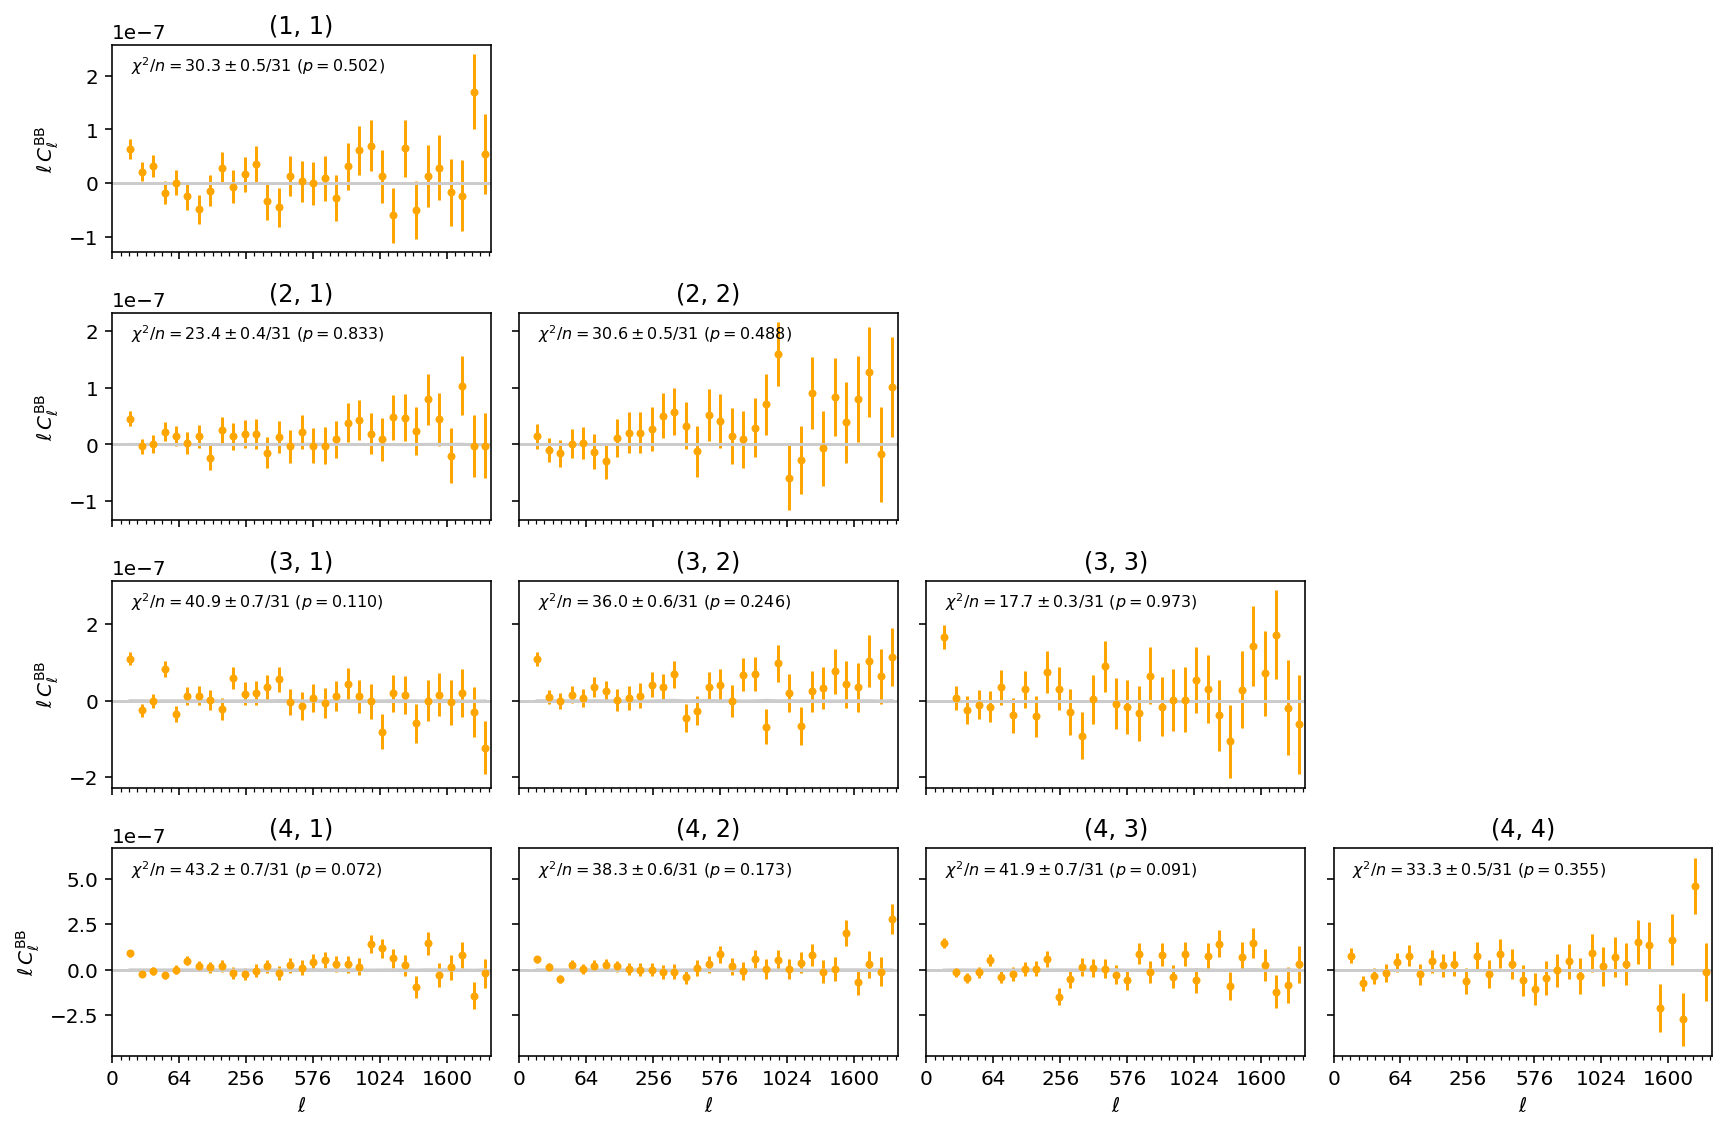

In [5]:
ell = np.copy(hm.ell)

nzbins = len(shear.zbins)
fig, axes = plt.subplots(4, 4, figsize=(12,8), sharex=True, sharey='row')

pairs = hm.get_pairs(shear)

# clbb_tatt = harm.utils.load_cosmosis_cl('../../params/test_template.fits_TATT_A1_1.50_A2_-3.00_BTA_1.00/shear_cl_bb/')

# Chi2 test bins
Lmin=1
Lmax=32

for i in range(1,5):
    for j in range(1,5):
        ax = axes[i-1,j-1]
        if (i,j) in pairs:
            ax.axhline(y=0, c='0.8')
            
            cl_m = hm.get_cl(shear, shear, i, j, debias=(i==j))[3]
            cl_r = hm.get_cl(shear, shear, i, j, which='random')[:,3]
            cl_err = cl_r.std(axis=0)

            if i!=j:
                ax.plot(hm.ell, hm.ell*hm.get_cl(shear, shear, i, j, which='random')[:,3].mean(axis=0), c='0.8')
            
#             chi2, pval = harm.utils.get_chi2(hm.get_cl(shear, shear, i, j, debias=False)[3,Lmin:Lmax], cl_r[:,Lmin:Lmax], smooth=False, return_pval=True)
            (chi2, pval), chi2_err = harm.utils.bootstrap_chi2(500, hm.get_cl(shear, shear, i, j, debias=False)[3,Lmin:Lmax], cl_r[:,Lmin:Lmax], smooth=False, return_pval=True)

            
            ax.errorbar(hm.ell, hm.ell*cl_m, hm.ell*cl_err, ls=' ', marker='o', c='orange', ms=3)
            ax.text(0.05,0.95,'$\\chi^2/n={:.1f}\pm{:.1f}/{}$ ($p={:.3f}$)'.format(chi2, chi2_err, len(cl_m[Lmin:Lmax]), pval),
                    ha='left', va='top', transform=ax.transAxes, fontsize=8)
#             xlim = ax.get_xlim()
#             ax.plot(clbb_tatt['ell'], clbb_tatt['ell']*clbb_tatt[i-1,j-1])
#             ax.set_xlim(xlim)
            
            ax.set_title(str((i,j)))
            if i==4:
                ax.set_xlabel('$\\ell$')
                ax.set_xscale('squareroot')
                ax.set_xticks(np.arange(0,np.sqrt(lmax),8)**2);
                ax.set_xticks(np.arange(0,np.sqrt(lmax),1)**2, minor=True);
                ax.set_xlim(0,2048)
            if j==1:
                ax.set_ylabel('$\ell \\, C_\\ell^{\\rm BB}$')
                
#             ax.legend(frameon=False, loc='upper left')

        else:
            ax.axis('off')
plt.tight_layout()

## Compute chi2 and test convergence

In [22]:
pairs = hm.get_pairs(shear)

Lmin=1
Lmax=32

dv   = np.concatenate([hm.get_cl(shear, shear, i, j, debias=(i==j))[3,Lmin:Lmax] for (i,j) in pairs])
dv_b = np.concatenate([hm.get_cl(shear, shear, i, j, debias=False)[3,Lmin:Lmax] for (i,j) in pairs])

dv_r = np.hstack([hm.get_cl(shear, shear, i, j, which='random')[:,3,Lmin:Lmax] for (i,j) in pairs])
cov = np.cov(dv_r, rowvar=False)
corr = np.corrcoef(dv_r, rowvar=False)

harm.utils.get_chi2(dv_b, dv_r, return_pval=True)

(337.4752685098211, 0.13588226636586895)

In [4]:
harm.utils.bootstrap_chi2(1000, dv_b, dv_r, return_pval=True, pbar=True)

((337.4752685098211, 0.13588226636586895), 5.271656501943007)

In [5]:
import scipy
scipy.stats.norm.isf(0.13588226636586895) # that's the right one :)
# scipy.stats.norm.interval(0.5)
# scipy.stats.norm.ppf(1.-0.13588226636586895)

1.0990081002193206

Text(0.5, 1.0, '$p$-value as function of number of randoms')

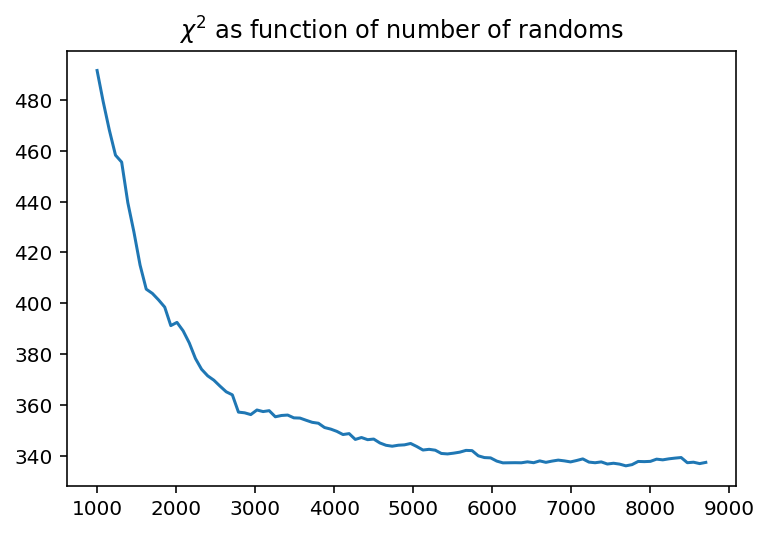

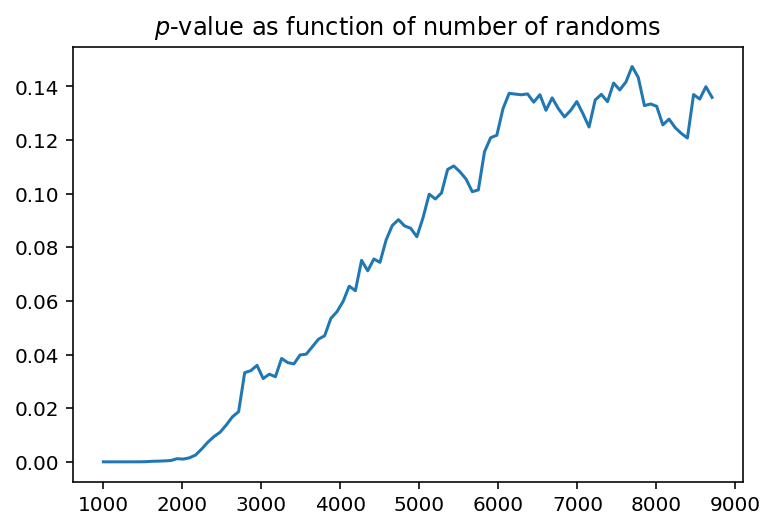

In [20]:
pairs = hm.get_pairs(shear)

Lmin=1
Lmax=32

dv   = np.concatenate([hm.get_cl(shear, shear, i, j, debias=(i==j))[3,Lmin:Lmax] for (i,j) in pairs])
dv_b = np.concatenate([hm.get_cl(shear, shear, i, j, debias=False)[3,Lmin:Lmax] for (i,j) in pairs])

dv_r = np.hstack([hm.get_cl(shear, shear, i, j, which='random')[:,3,Lmin:Lmax] for (i,j) in pairs])
# cov = np.cov(dv_r, rowvar=False)
# corr = np.corrcoef(dv_r, rowvar=False)

chi2_list = []
nn_r = np.linspace(1000,len(dv_r),100).astype(int)
for n in tqdm(nn_r):
    chi2_list.append(harm.utils.get_chi2(dv_b, dv_r[:n], return_pval=True))
chi2_list = np.array(chi2_list)

plt.plot(nn_r, chi2_list[:,0])
plt.title('$\\chi^2$ as function of number of randoms')
plt.figure()
plt.plot(nn_r, chi2_list[:,1])
plt.title('$p$-value as function of number of randoms')


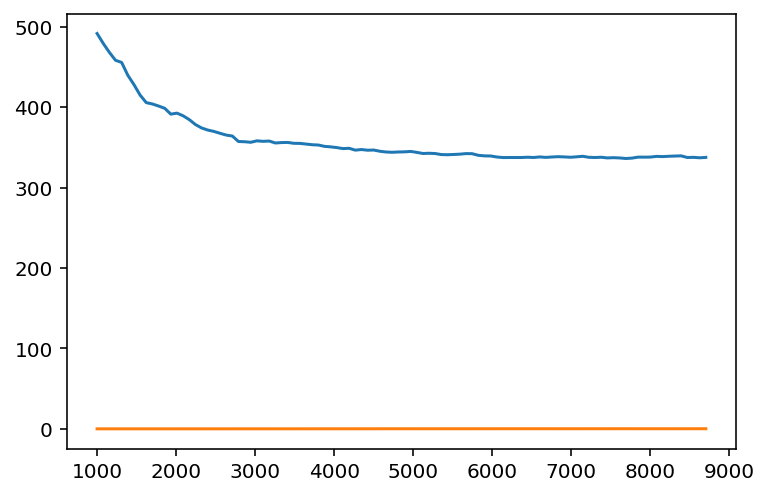

In [14]:
plt.plot(nn_r, chi2_list)

In [18]:
np.array(chi2_list).shape

(100, 2)

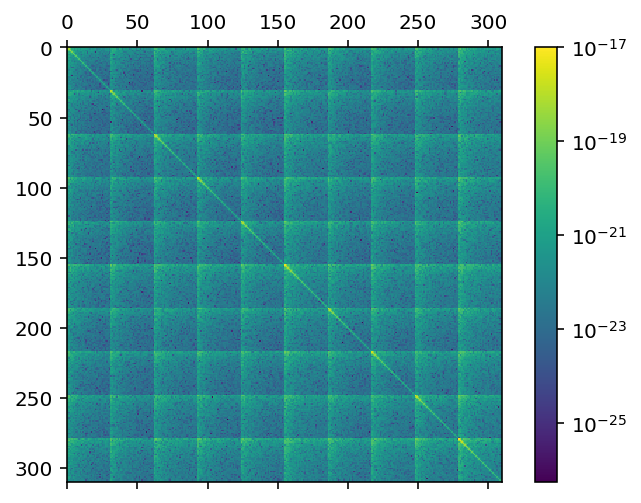

In [6]:
# plt.figure(figsize=(18,16))
plt.matshow(np.abs(cov), fignum=0, norm=mpl.colors.LogNorm())
plt.colorbar()

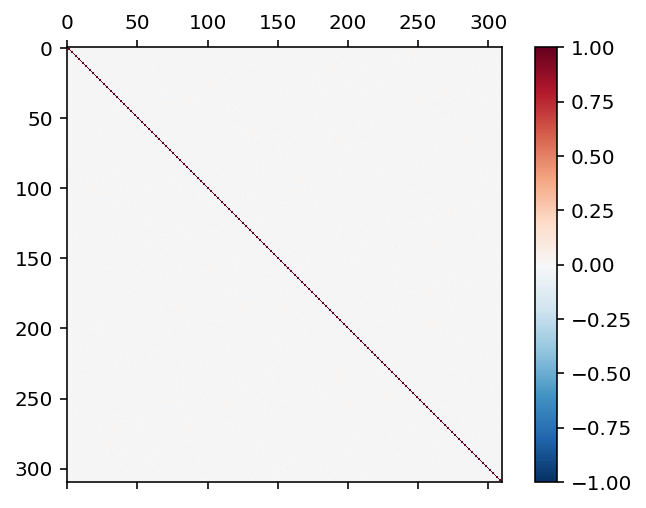

In [7]:
# plt.figure(figsize=(18,16))
plt.matshow(corr, fignum=0, vmin=-1, vmax=1, cmap=mpl.cm.RdBu_r) #norm=mpl.colors.SymLogNorm(1e-2)
plt.colorbar()

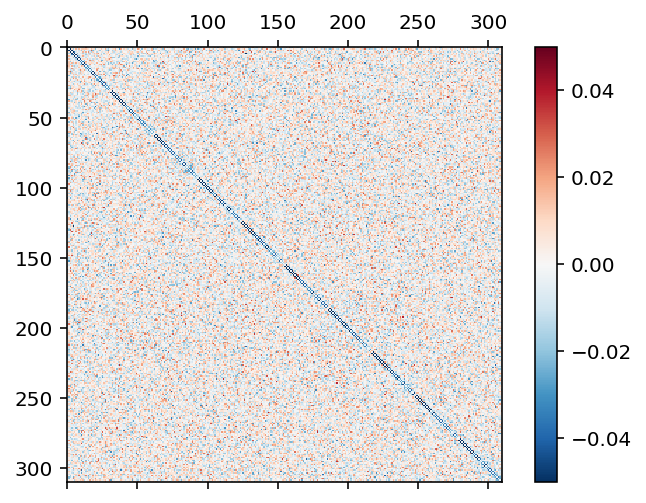

In [14]:
plt.matshow(corr-np.identity(corr.shape[0]), fignum=0, cmap=mpl.cm.RdBu_r, vmin=-.05, vmax=.05) #norm=mpl.colors.SymLogNorm(1e-2)
plt.colorbar()

In [15]:
np.unique(dv_r, axis=0).shape

(8704, 310)

In [16]:
dv_r.shape

(8704, 310)

## Add randoms

In [2]:
import pickle
output_dir = '/global/cfs/cdirs/des/xuod/DES_Y3_shear_analysis/outputs/Y3_mastercat_12_3_19_v3_Bmode_tomo_highell_nopureE_countmode_C1_apo0.0'
filename = 'cls_random_isim{}_Y3_mastercat_12_3_19_v3_Bmode_tomo_highell_nopureE_countmode_C1_apo0.0_nside1024.pickle'

pairs = hm.get_pairs(shear, shear)
cl_temp = {}
for x in pairs:
    cl_temp[x] = []

for isim in range(100,200):
    try:
        test_cl = pickle.load(open(os.path.join(output_dir, filename.format(isim)), 'rb'))
        for x in pairs:
            cl_temp[x].append(test_cl['galaxy_shear','galaxy_shear'][x]['random'])
    except:
        print(isim)

for x in pairs:
    cl_temp[x] = np.concatenate(cl_temp[x], axis=0)

108
109
114
115


In [3]:
for i, j in pairs:
    hm._add_to_random(shear, shear, i, j, cl_temp[i,j])

Adding to existing randoms.
Adding to existing randoms.
Adding to existing randoms.
Adding to existing randoms.
Adding to existing randoms.
Adding to existing randoms.
Adding to existing randoms.
Adding to existing randoms.
Adding to existing randoms.
Adding to existing randoms.


In [4]:
hm.save_cls()

In [4]:
test_cl.keys(), test_cl['galaxy_shear','galaxy_shear'].keys()

(dict_keys([('galaxy_shear', 'galaxy_shear')]),
 dict_keys([(1, 1), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3), (4, 4)]))

In [6]:
test_cl['galaxy_shear','galaxy_shear'][1,1]['random'].shape

(32, 4, 32)

## Build B-mode Cl/xis covariance

In [186]:
df

,e1std,e2std,e12std,fsky,Ngal,area (std),area (sq. deg.),nbar (gal/std),nbar (gal/arcmin)
1,0.282742,0.283254,0.400220,0.115063,27288607,1.445920,4746.674388,1.887284e+07,1.596943
2,0.309382,0.309539,0.437643,0.115045,27636385,1.445697,4745.943284,1.911631e+07,1.617544
3,0.375572,0.377104,0.532223,0.114992,27511058,1.445030,4743.753253,1.903840e+07,1.610952
4,0.425020,0.422254,0.599116,0.114875,27486242,1.443567,4738.950264,1.904051e+07,1.611130


In [187]:
def delta(a,b):
    if a==b:
        return 1.
    else:
        return 0.

In [433]:
path_cl_to_xi_fullsky = '/global/homes/x/xuod/codes/cosmosis/cosmosis-standard-library/shear/cl_to_xi_fullsky/'
sys.path.insert(0, path_cl_to_xi_fullsky)
import legendre, cl_to_xi

lmax = 3000
ells = np.arange(lmax+1)
thetas_edges = np.geomspace(2.5, 250., 21) * np.pi/(180.*60.)
thetas = np.exp(0.5*(np.log(thetas_edges[1:])+np.log(thetas_edges[:-1])))
leg_xip, leg_xim = cl_to_xi.get_legfactors_22(ells, thetas)

leg_xipm = np.concatenate([leg_xip, -1.*leg_xim], axis=0)

/global/homes/x/xuod/codes/cosmosis/cosmosis-standard-library/shear/cl_to_xi_fullsky/legendre.py:16: RuntimeWarning: divide by zero encountered in true_divide
  N_ell = np.sqrt(2. / (ell - 1) / ell / (ell + 1) / (ell + 2))
/global/homes/x/xuod/codes/cosmosis/cosmosis-standard-library/shear/cl_to_xi_fullsky/legendre.py:16: RuntimeWarning: invalid value encountered in sqrt
  N_ell = np.sqrt(2. / (ell - 1) / ell / (ell + 1) / (ell + 2))


In [434]:
leg_xip.shape

(20, 3001)

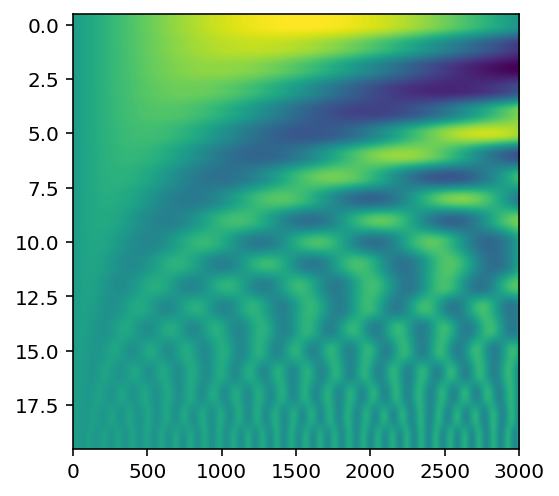

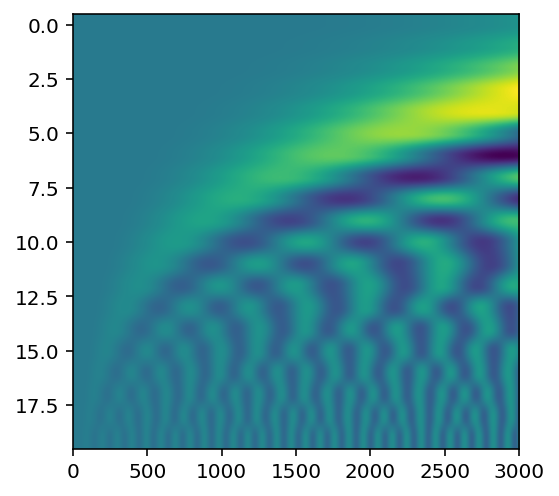

In [435]:
plt.figure(figsize=(4,4))
plt.imshow(leg_xip, aspect='auto')

plt.figure(figsize=(4,4))
plt.imshow(leg_xim, aspect='auto')

In [436]:
pairs = hm.get_pairs(shear)

hp_pixwin = hp.pixwin(nside)

cov_BB_xip_dict = {}
for a,b in pairs:
    for c,d in pairs:
        cov_temp = np.zeros((n_ell_bins,len(thetas)))
        for il in range(n_ell_bins):
            L_ell = np.array(hm.b.get_ell_list(il))
            Delta_ell = len(L_ell)
            noise_a = df['e1std'][a]**2 / df['nbar (gal/std)'][a] / np.sqrt(df['fsky'][a])
            noise_b = df['e1std'][b]**2 / df['nbar (gal/std)'][b] / np.sqrt(df['fsky'][b])

            cov_temp[il] = np.sum(leg_xip[:,L_ell] *
                                  (delta(a,c)*delta(b,d) + delta(a,d)*delta(b,c)) * (noise_a*noise_b) /
                                  (Delta_ell*(2.*L_ell+1.)*hp_pixwin[L_ell]**0), axis=1)
            
            cov_BB_xip_dict[a,b,c,d] = cov_temp
            
cov_BB_xim_dict = {}
for a,b in pairs:
    for c,d in pairs:
        cov_temp = np.zeros((n_ell_bins,len(thetas)))
        for il in range(n_ell_bins):
            L_ell = np.array(hm.b.get_ell_list(il))
            Delta_ell = len(L_ell)
            noise_a = df['e1std'][a]**2 / df['nbar (gal/std)'][a] / np.sqrt(df['fsky'][a])
            noise_b = df['e1std'][b]**2 / df['nbar (gal/std)'][b] / np.sqrt(df['fsky'][b])

            cov_temp[il] = -1.0 * np.sum(leg_xim[:,L_ell] *
                                  (delta(a,c)*delta(b,d) + delta(a,d)*delta(b,c)) * (noise_a*noise_b) /
                                  (Delta_ell*(2.*L_ell+1.)*hp_pixwin[L_ell]**0), axis=1)
            
            cov_BB_xim_dict[a,b,c,d] = cov_temp

In [437]:
tp = fits.open('../../y3-cosmic-shear/code/forecast/2pt_sim_1110_baseline_Y3cov.fits')
cov_xipm = tp['COVMAT'].data[:400,:400]

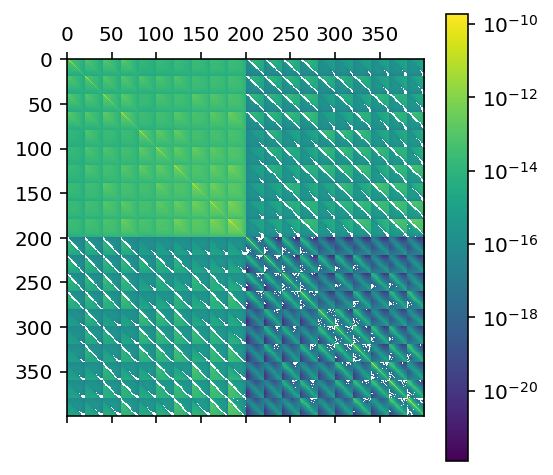

In [438]:
plt.matshow(cov_xipm, norm=mpl.colors.LogNorm())
plt.colorbar()

In [439]:
pairs_tp = [(j,i) for i,j in zip(tp['xip'].data['BIN1'][::20], tp['xip'].data['BIN2'][::20])]

In [440]:
cov_BB_xipm = np.zeros((n_ell_bins*len(pairs),2*len(thetas)*len(pairs)))
for iab, (a,b) in enumerate(pairs):
    for icd, (c,d) in enumerate(pairs_tp):
        cov_BB_xipm[iab*n_ell_bins:(iab+1)*n_ell_bins, icd*len(thetas):(icd+1)*len(thetas)] = cov_BB_xip_dict[a,b,c,d]
        cov_BB_xipm[iab*n_ell_bins:(iab+1)*n_ell_bins, 200+icd*len(thetas):200+(icd+1)*len(thetas)] = cov_BB_xim_dict[a,b,c,d]

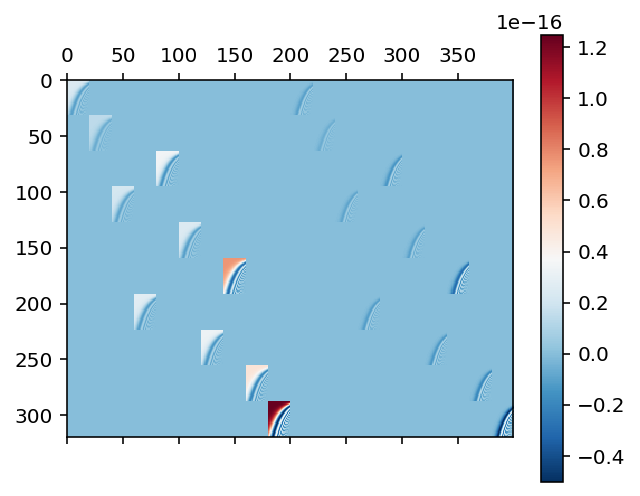

In [441]:
plt.matshow(cov_BB_xipm, cmap=mpl.cm.RdBu_r)
plt.colorbar()

In [442]:
pairs, pairs_tp

([(1, 1),
  (2, 1),
  (2, 2),
  (3, 1),
  (3, 2),
  (3, 3),
  (4, 1),
  (4, 2),
  (4, 3),
  (4, 4)],
 [(1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (2, 2),
  (3, 2),
  (4, 2),
  (3, 3),
  (4, 3),
  (4, 4)])

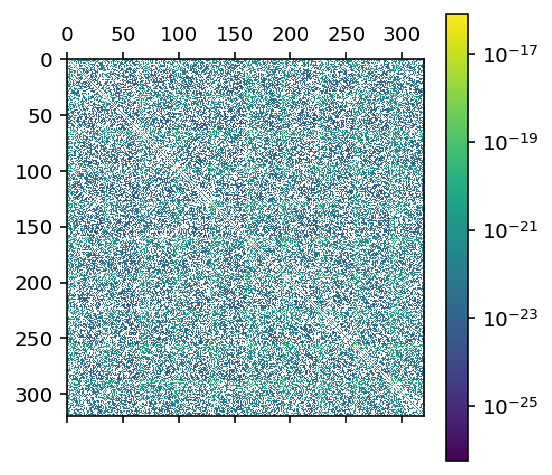

In [443]:
dv_r = np.hstack([hm.get_cl(shear, shear, i, j, which='random')[:,3,:] for (i,j) in pairs])
cov_BB = np.cov(dv_r, rowvar=False)

plt.matshow(cov_BB, norm=mpl.colors.LogNorm())
plt.colorbar()

In [444]:
cov_BB_th = np.zeros_like(cov_BB)

hp_pixwin = hp.pixwin(nside)
for iab, (a,b) in enumerate(pairs):
    for icd, (c,d) in enumerate(pairs):
        for il in range(n_ell_bins):
            L_ell = np.array(hm.b.get_ell_list(il))
            Delta_ell = len(L_ell) *1.
            noise_a = df['e1std'][a]**2 / df['nbar (gal/std)'][a] / np.sqrt(df['fsky'][a])
            noise_b = df['e1std'][b]**2 / df['nbar (gal/std)'][b] / np.sqrt(df['fsky'][b])
            cov_BB_th[iab*n_ell_bins+il, icd*n_ell_bins+il] = np.sum((delta(a,c)*delta(b,d) + delta(a,d)*delta(b,c)) * (noise_a*noise_b) / (Delta_ell**2*(2.*L_ell+1.)*hp_pixwin[L_ell]**4))
            

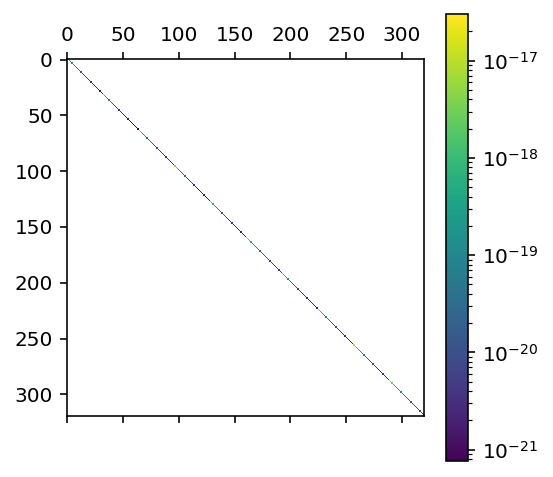

In [445]:
plt.matshow(cov_BB_th, norm=mpl.colors.LogNorm())
plt.colorbar()

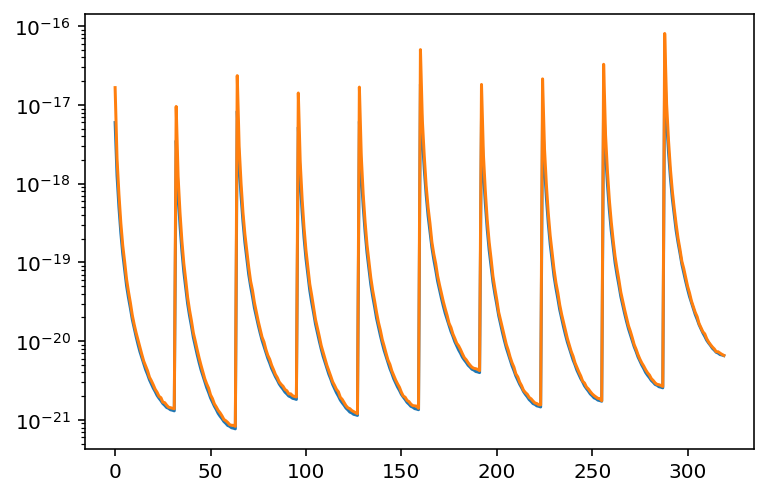

In [446]:
plt.plot(cov_BB_th.diagonal())
plt.plot(cov_BB.diagonal())
plt.yscale('log')

In [447]:
m_BB = n_ell_bins*len(pairs)
m_xipm = 2*len(thetas)*len(pairs)
m_tot = m_BB+m_xipm
full_cov_BB_xipm = np.zeros((m_tot,m_tot))
full_cov_BB_xipm[:m_BB,:m_BB] = cov_BB_th
# full_cov_BB_xipm[:m_BB,:m_BB] = cov_BB
full_cov_BB_xipm[:m_BB,m_BB:] = cov_BB_xipm
full_cov_BB_xipm[m_BB:,:m_BB] = cov_BB_xipm.T
full_cov_BB_xipm[m_BB:,m_BB:] = cov_xipm

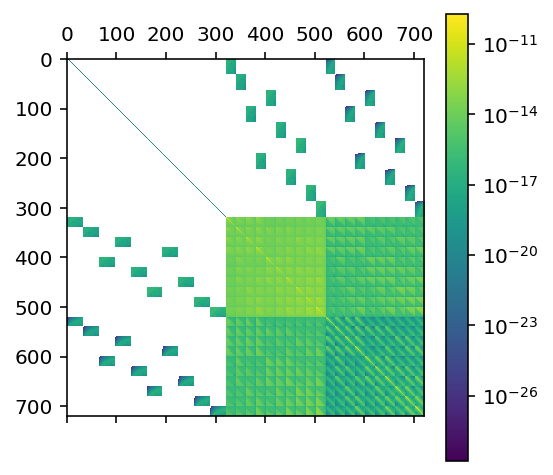

In [448]:
plt.matshow(np.abs(full_cov_BB_xipm), norm=mpl.colors.LogNorm())
plt.colorbar()

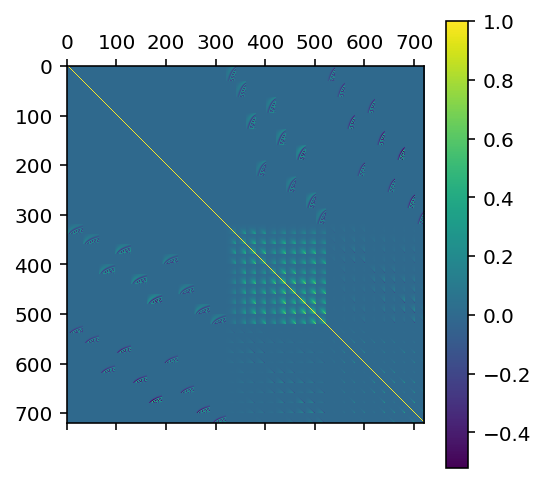

In [449]:
plt.matshow(ca.maths.matrix_normbydiag(full_cov_BB_xipm))#, norm=mpl.colors.LogNorm())
plt.colorbar()

In [450]:
print(np.linalg.slogdet(cov_BB))
print(np.linalg.slogdet(cov_xipm))
print(np.linalg.slogdet(full_cov_BB_xipm))

(1.0, -14574.061303966817)
(1.0, -11236.935347205546)
(1.0, -25953.030917588007)


In [451]:
np.allclose(full_cov_BB_xipm, full_cov_BB_xipm.T)

True

In [456]:
def conditional_multivariate_normal(mu, cov, a2, ind2):
    # Using notations from https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions
    import scipy.stats
    
    ind1 = np.setdiff1d(np.arange(len(mu)), ind2)
    sig11 = cov[ind1,:][:,ind1]
    sig12 = cov[ind1,:][:,ind2]
    sig21 = cov[ind2,:][:,ind1]
    sig22inv = np.linalg.inv(cov[ind2,:][:,ind2])
#     print(a2)
#     print(mu[ind2])
    mubar = mu[ind1] + np.dot(sig12,np.dot(sig22inv,(a2-mu[ind2])))
    sigbar = sig11 - np.dot(sig12,np.dot(sig22inv,sig21))
    
#     print("ERROR")
#     print(np.linalg.slogdet(sigbar))
#     print(np.linalg.eigvals(sigbar))
#     plt.plot(np.linalg.eigvals(sigbar))
    
    return mubar
#     return scipy.stats.multivariate_normal(mean=mubar, cov=sigbar, allow_singular=True)


In [457]:
mu = np.concatenate([np.zeros(m_BB), tp['xip'].data['VALUE'], tp['xim'].data['VALUE']])
dv = np.concatenate([hm.get_cl(shear, shear, i, j, debias=(i==j))[3,:] for (i,j) in pairs])
dist_xipm_cond_BB = conditional_multivariate_normal(mu, full_cov_BB_xipm, dv, np.arange(m_BB))

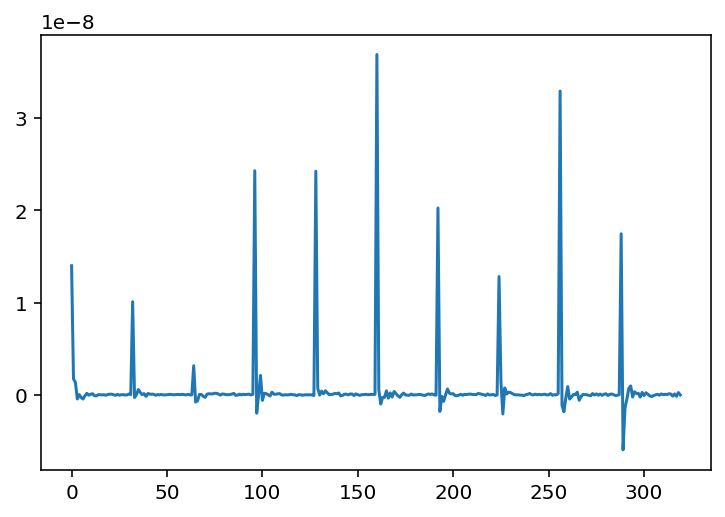

In [458]:
plt.plot(dv)

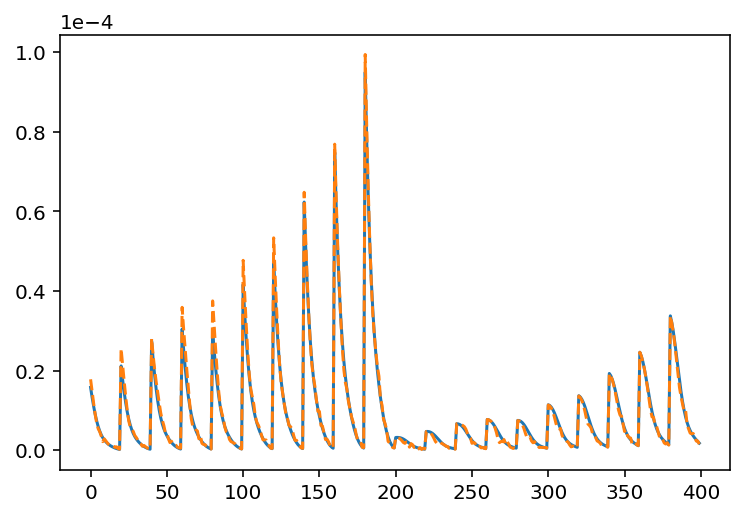

In [459]:
mu_xipm_th = np.concatenate([tp['xip'].data['VALUE'], tp['xim'].data['VALUE']])
mu_xipm_BB = conditional_multivariate_normal(mu, full_cov_BB_xipm, dv, np.arange(m_BB))#.rvs()
plt.plot(mu_xipm_th)
plt.plot(mu_xipm_BB, ls='--')

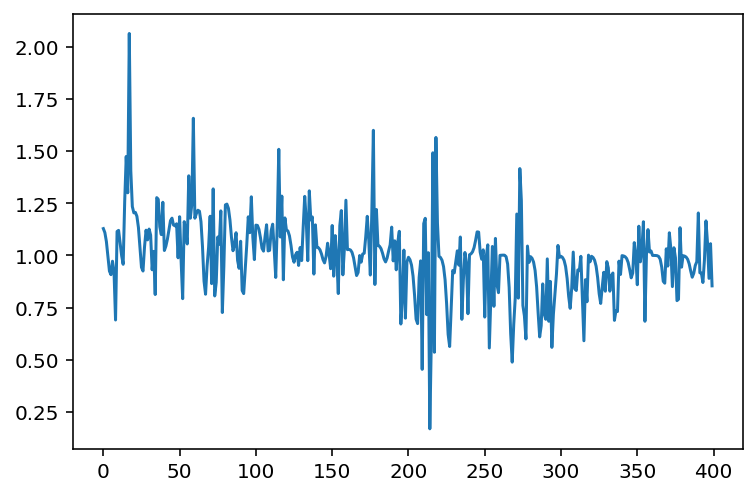

In [460]:
plt.plot(mu_xipm_BB/mu_xipm_th)

In [462]:
tp_new = fits.open('../../y3-cosmic-shear/code/forecast/2pt_sim_1110_baseline_Y3cov.fits')
tp_new['xip'].data['VALUE'] = mu_xipm_BB[:200]
tp_new['xim'].data['VALUE'] = mu_xipm_BB[200:]
tp_new.writeto('../../y3-cosmic-shear/code/bmode_tests/2pt_sim_1110_baseline_Y3cov_Bmode_contaminated.fits', overwrite=True)

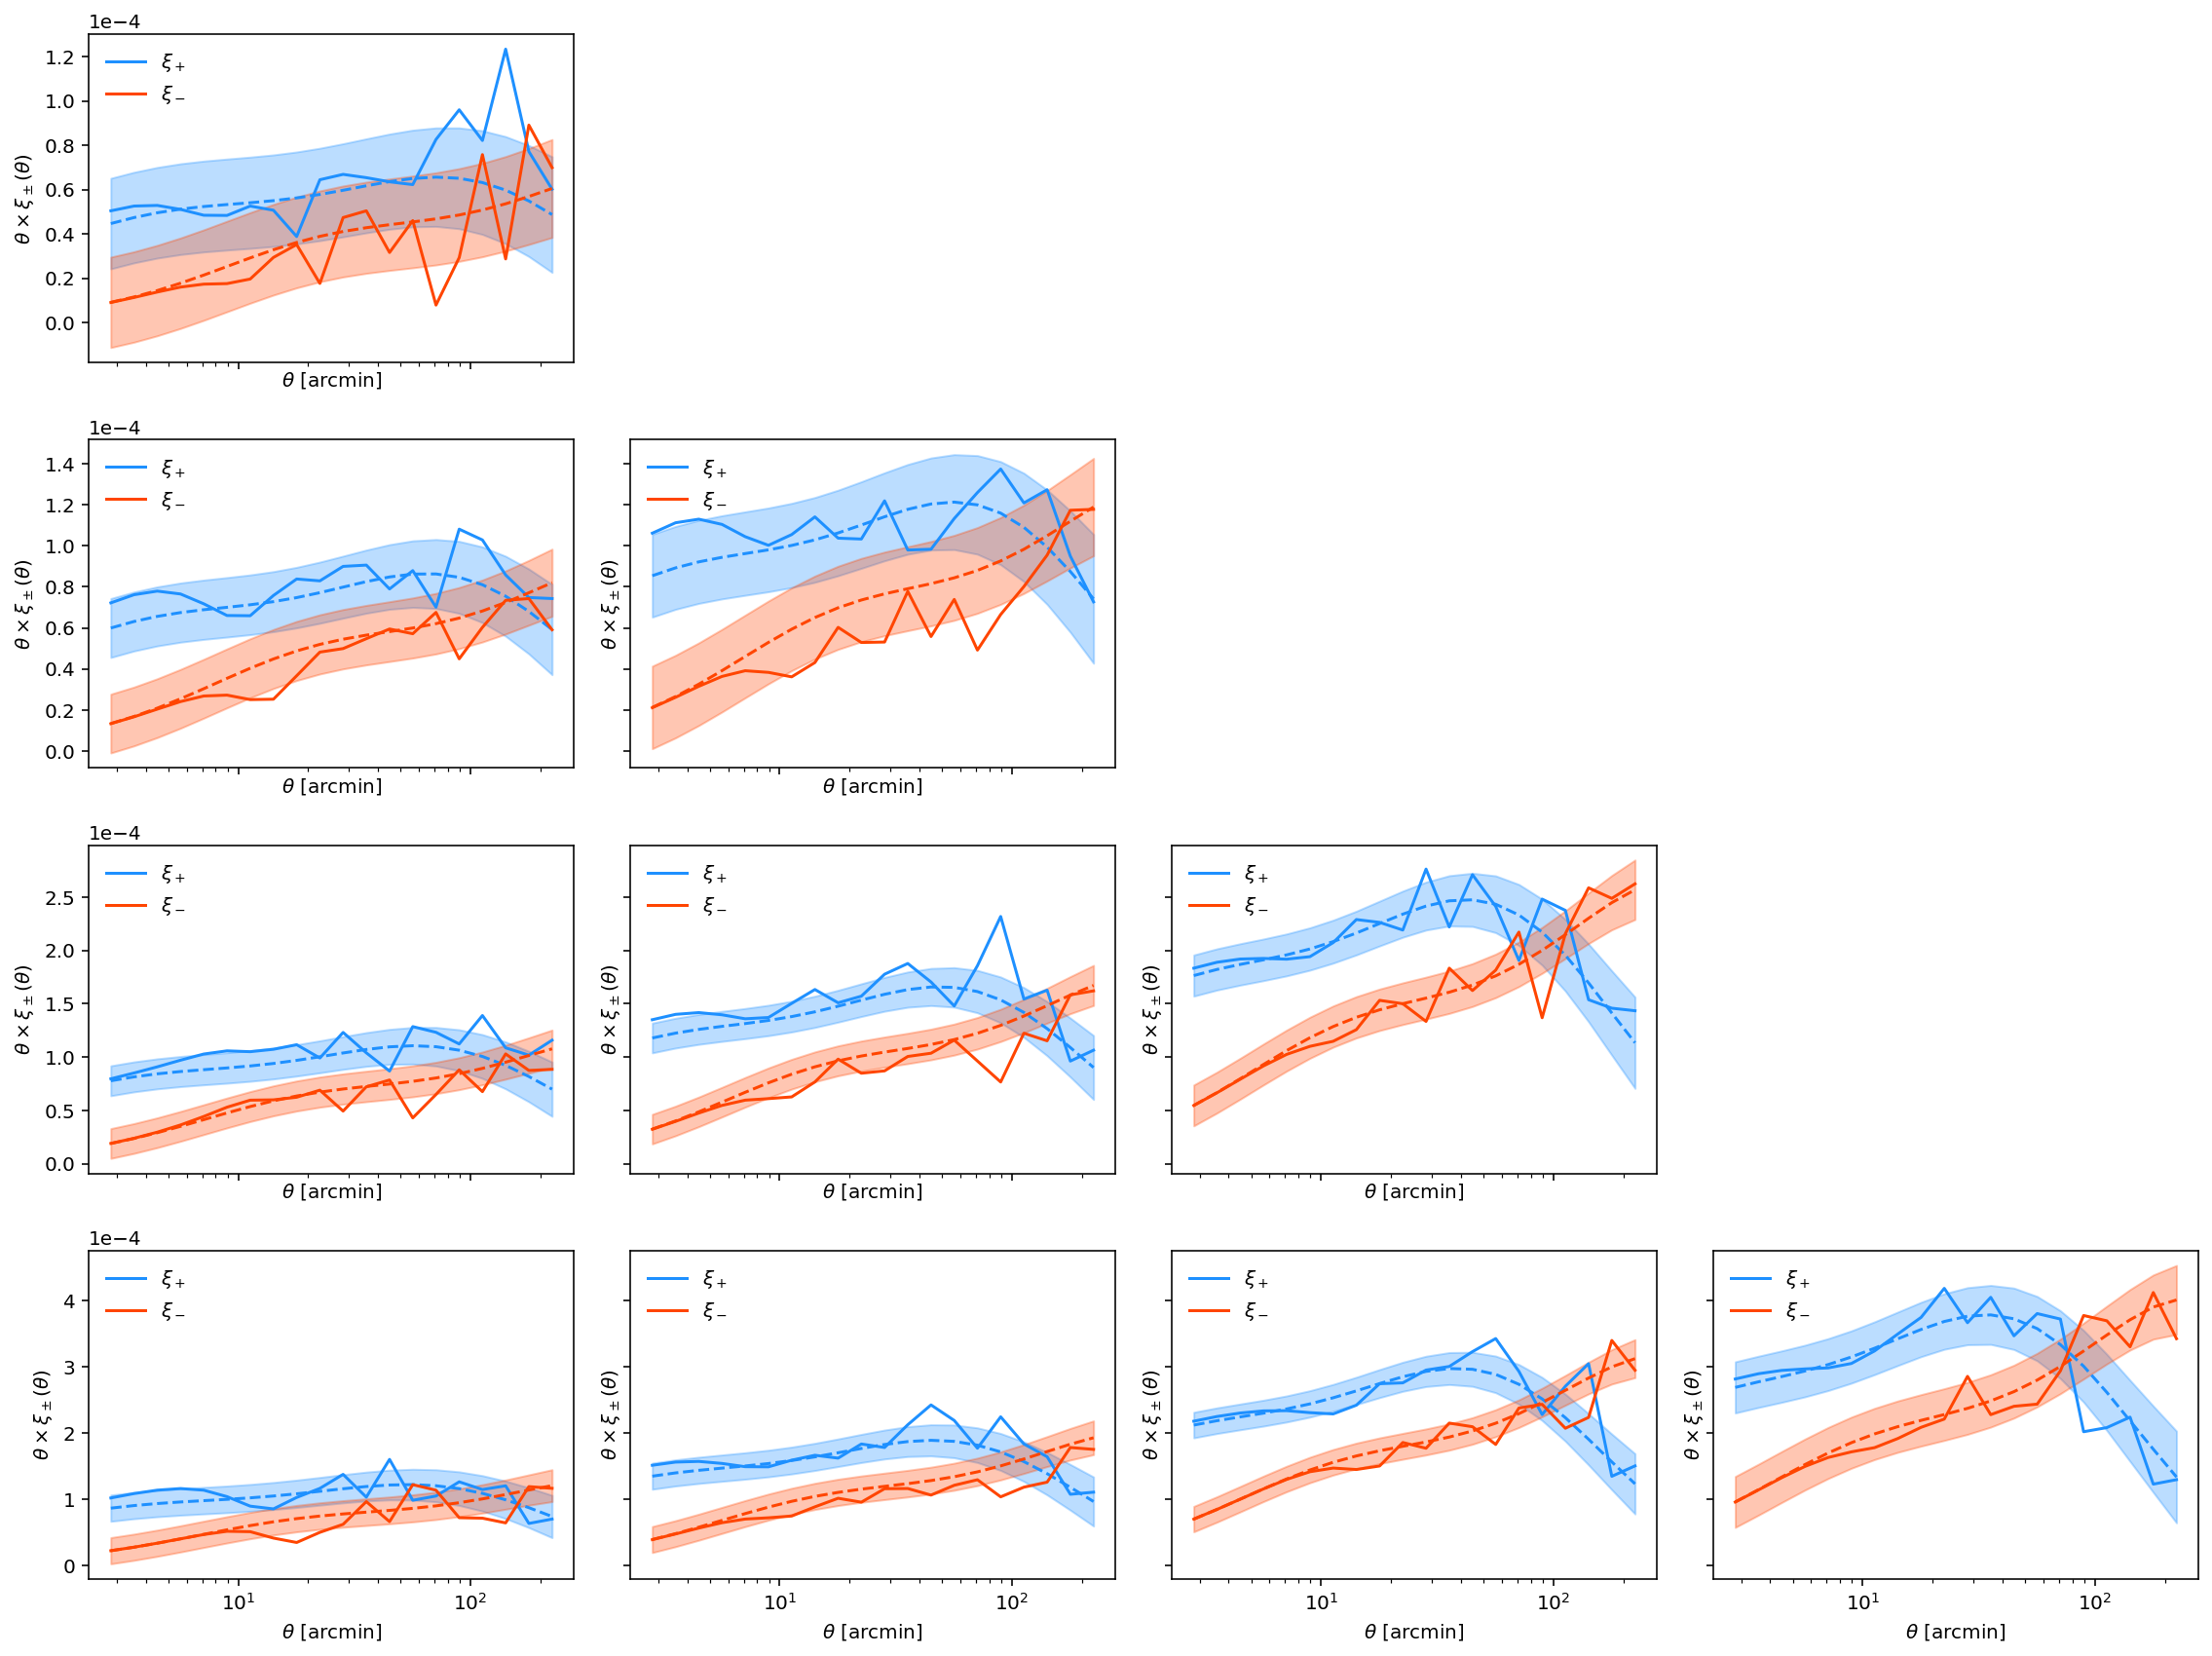

In [463]:
fig, axes = plt.subplots(4,4,figsize=(16,12), sharex=True, sharey='row')

tt = tp['xip'].data['ANG'][:20]

mpl.rcParams['axes.formatter.limits'] = (-3,4)

for i in range(4):
    for j in range(4):
        w = (tp['xip'].data['BIN1'] == i+1) & (tp['xip'].data['BIN2'] == j+1)
        ax = axes[j,i]
        if np.sum(w)>0:
            assert np.sum(w)==20
            ax.plot(tt, tt*mu_xipm_th[:200][w], c='dodgerblue', ls='--')
            ax.fill_between(tt, tt*(mu_xipm_th[:200][w]+np.sqrt(np.diagonal(tp['COVMAT'].data[:200,:200][w,:][:,w]))),
                                tt*(mu_xipm_th[:200][w]-np.sqrt(np.diagonal(tp['COVMAT'].data[:200,:200][w,:][:,w]))),
                                color='dodgerblue', alpha=0.3)
            ax.plot(tt, tt*mu_xipm_BB[:200][w], c='dodgerblue', ls='-', label='$\\xi_+$')
            
            ax.plot(tt, tt*mu_xipm_th[200:][w], c='orangered', ls='--')
            ax.fill_between(tt, tt*(mu_xipm_th[200:400][w]+np.sqrt(np.diagonal(tp['COVMAT'].data[200:400,200:400][w,:][:,w]))),
                                tt*(mu_xipm_th[200:400][w]-np.sqrt(np.diagonal(tp['COVMAT'].data[200:400,200:400][w,:][:,w]))),
                                color='orangered', alpha=0.3)
            ax.plot(tt, tt*mu_xipm_BB[200:][w], c='orangered', ls='-', label='$\\xi_-$')
            
            ax.set_xscale('log')
            ax.set_xlabel('$\\theta$ [arcmin]')
            ax.set_ylabel('$\\theta \\times \\xi_\\pm (\\theta)$')
            ax.legend(loc=2, frameon=False)
        else:
            ax.axis('off')

plt.tight_layout()

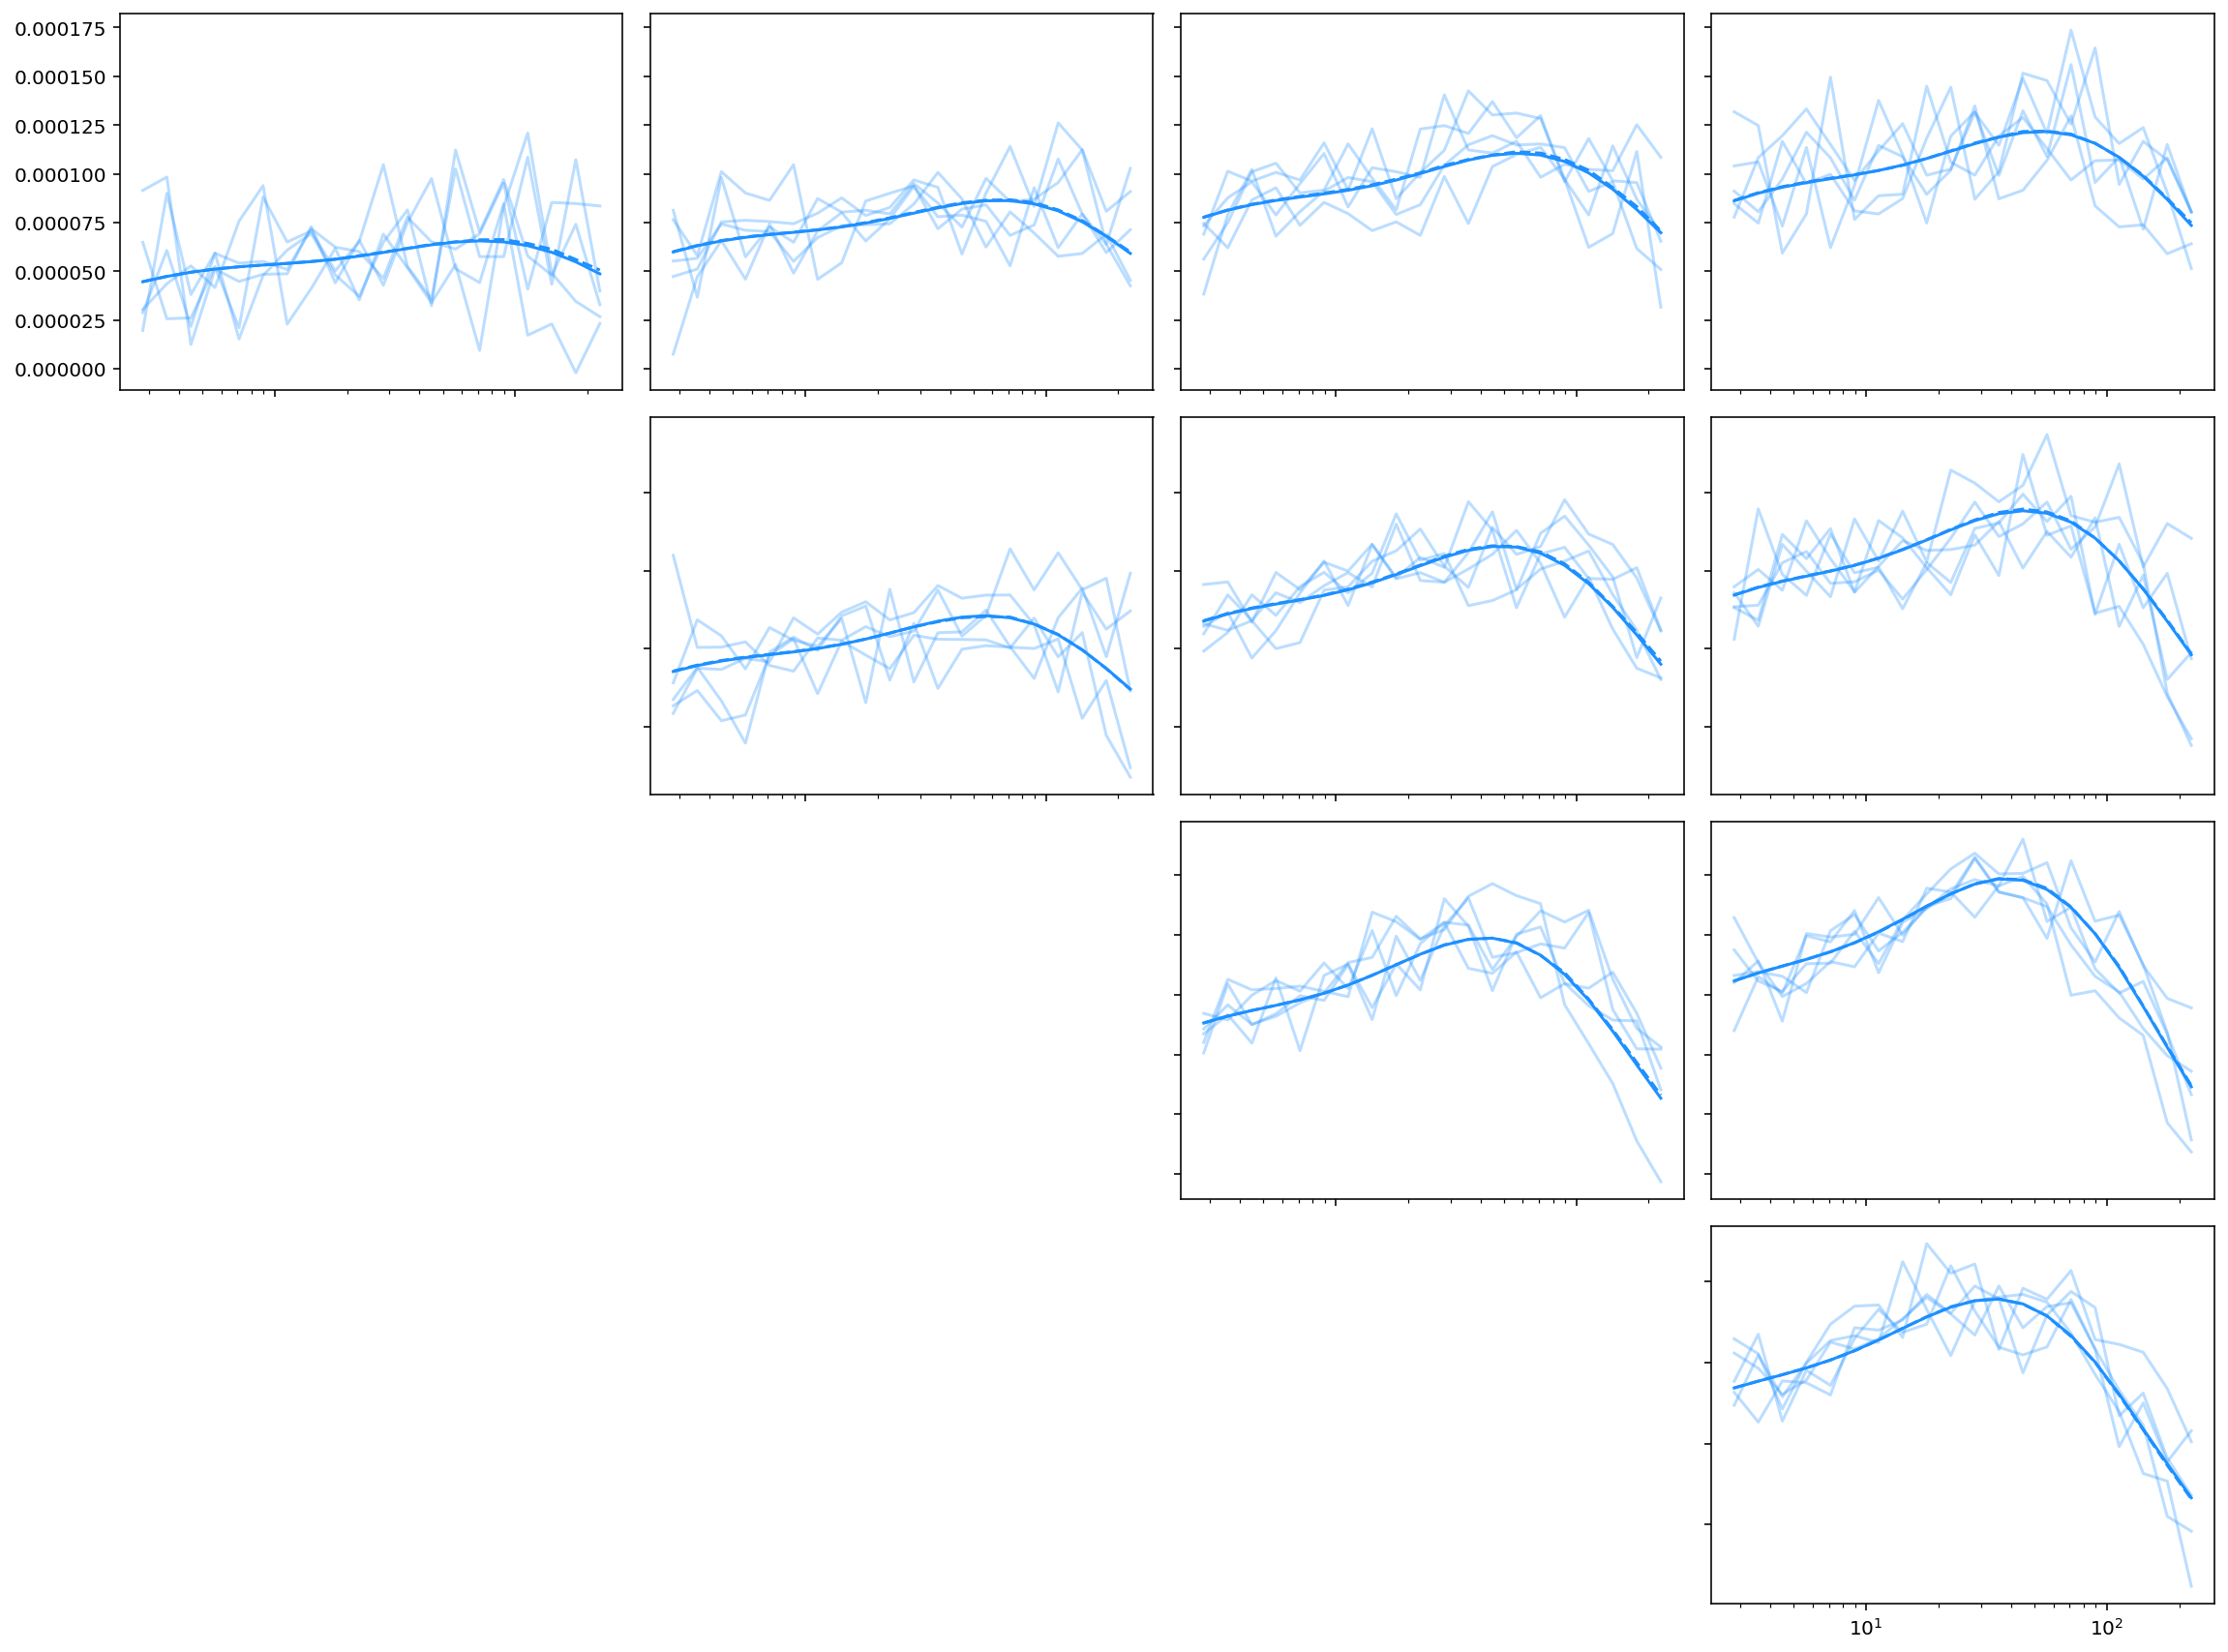

In [207]:
fig, axes = plt.subplots(4,4,figsize=(16,12), sharex=True, sharey='row')

tt = tp['xip'].data['ANG'][:20]

dist = conditional_multivariate_normal(mu, full_cov_BB_xipm, dv, np.arange(m_BB))

for i in range(4):
    for j in range(4):
        w = (tp['xip'].data['BIN1'] == i+1) & (tp['xip'].data['BIN2'] == j+1)
        ax = axes[i,j]
        if np.sum(w)>0:
            assert np.sum(w)==20
            ax.plot(tt, tt*mu_xipm_th[:200][w], c='dodgerblue')
            ax.plot(tt, tt*dist.mean[:200][w], c='dodgerblue', ls='--')
#             ax.plot(tt, tt*mu_xipm_th[200:][w])
            for _ in range(5):
                mu_xipm_BB = dist.rvs()
                ax.plot(tt, tt*mu_xipm_BB[:200][w], c='dodgerblue', alpha=0.3)
#             ax.plot(tt, tt*mu_xipm_BB[200:][w])
            ax.set_xscale('log')
        else:
            ax.axis('off')

plt.tight_layout()

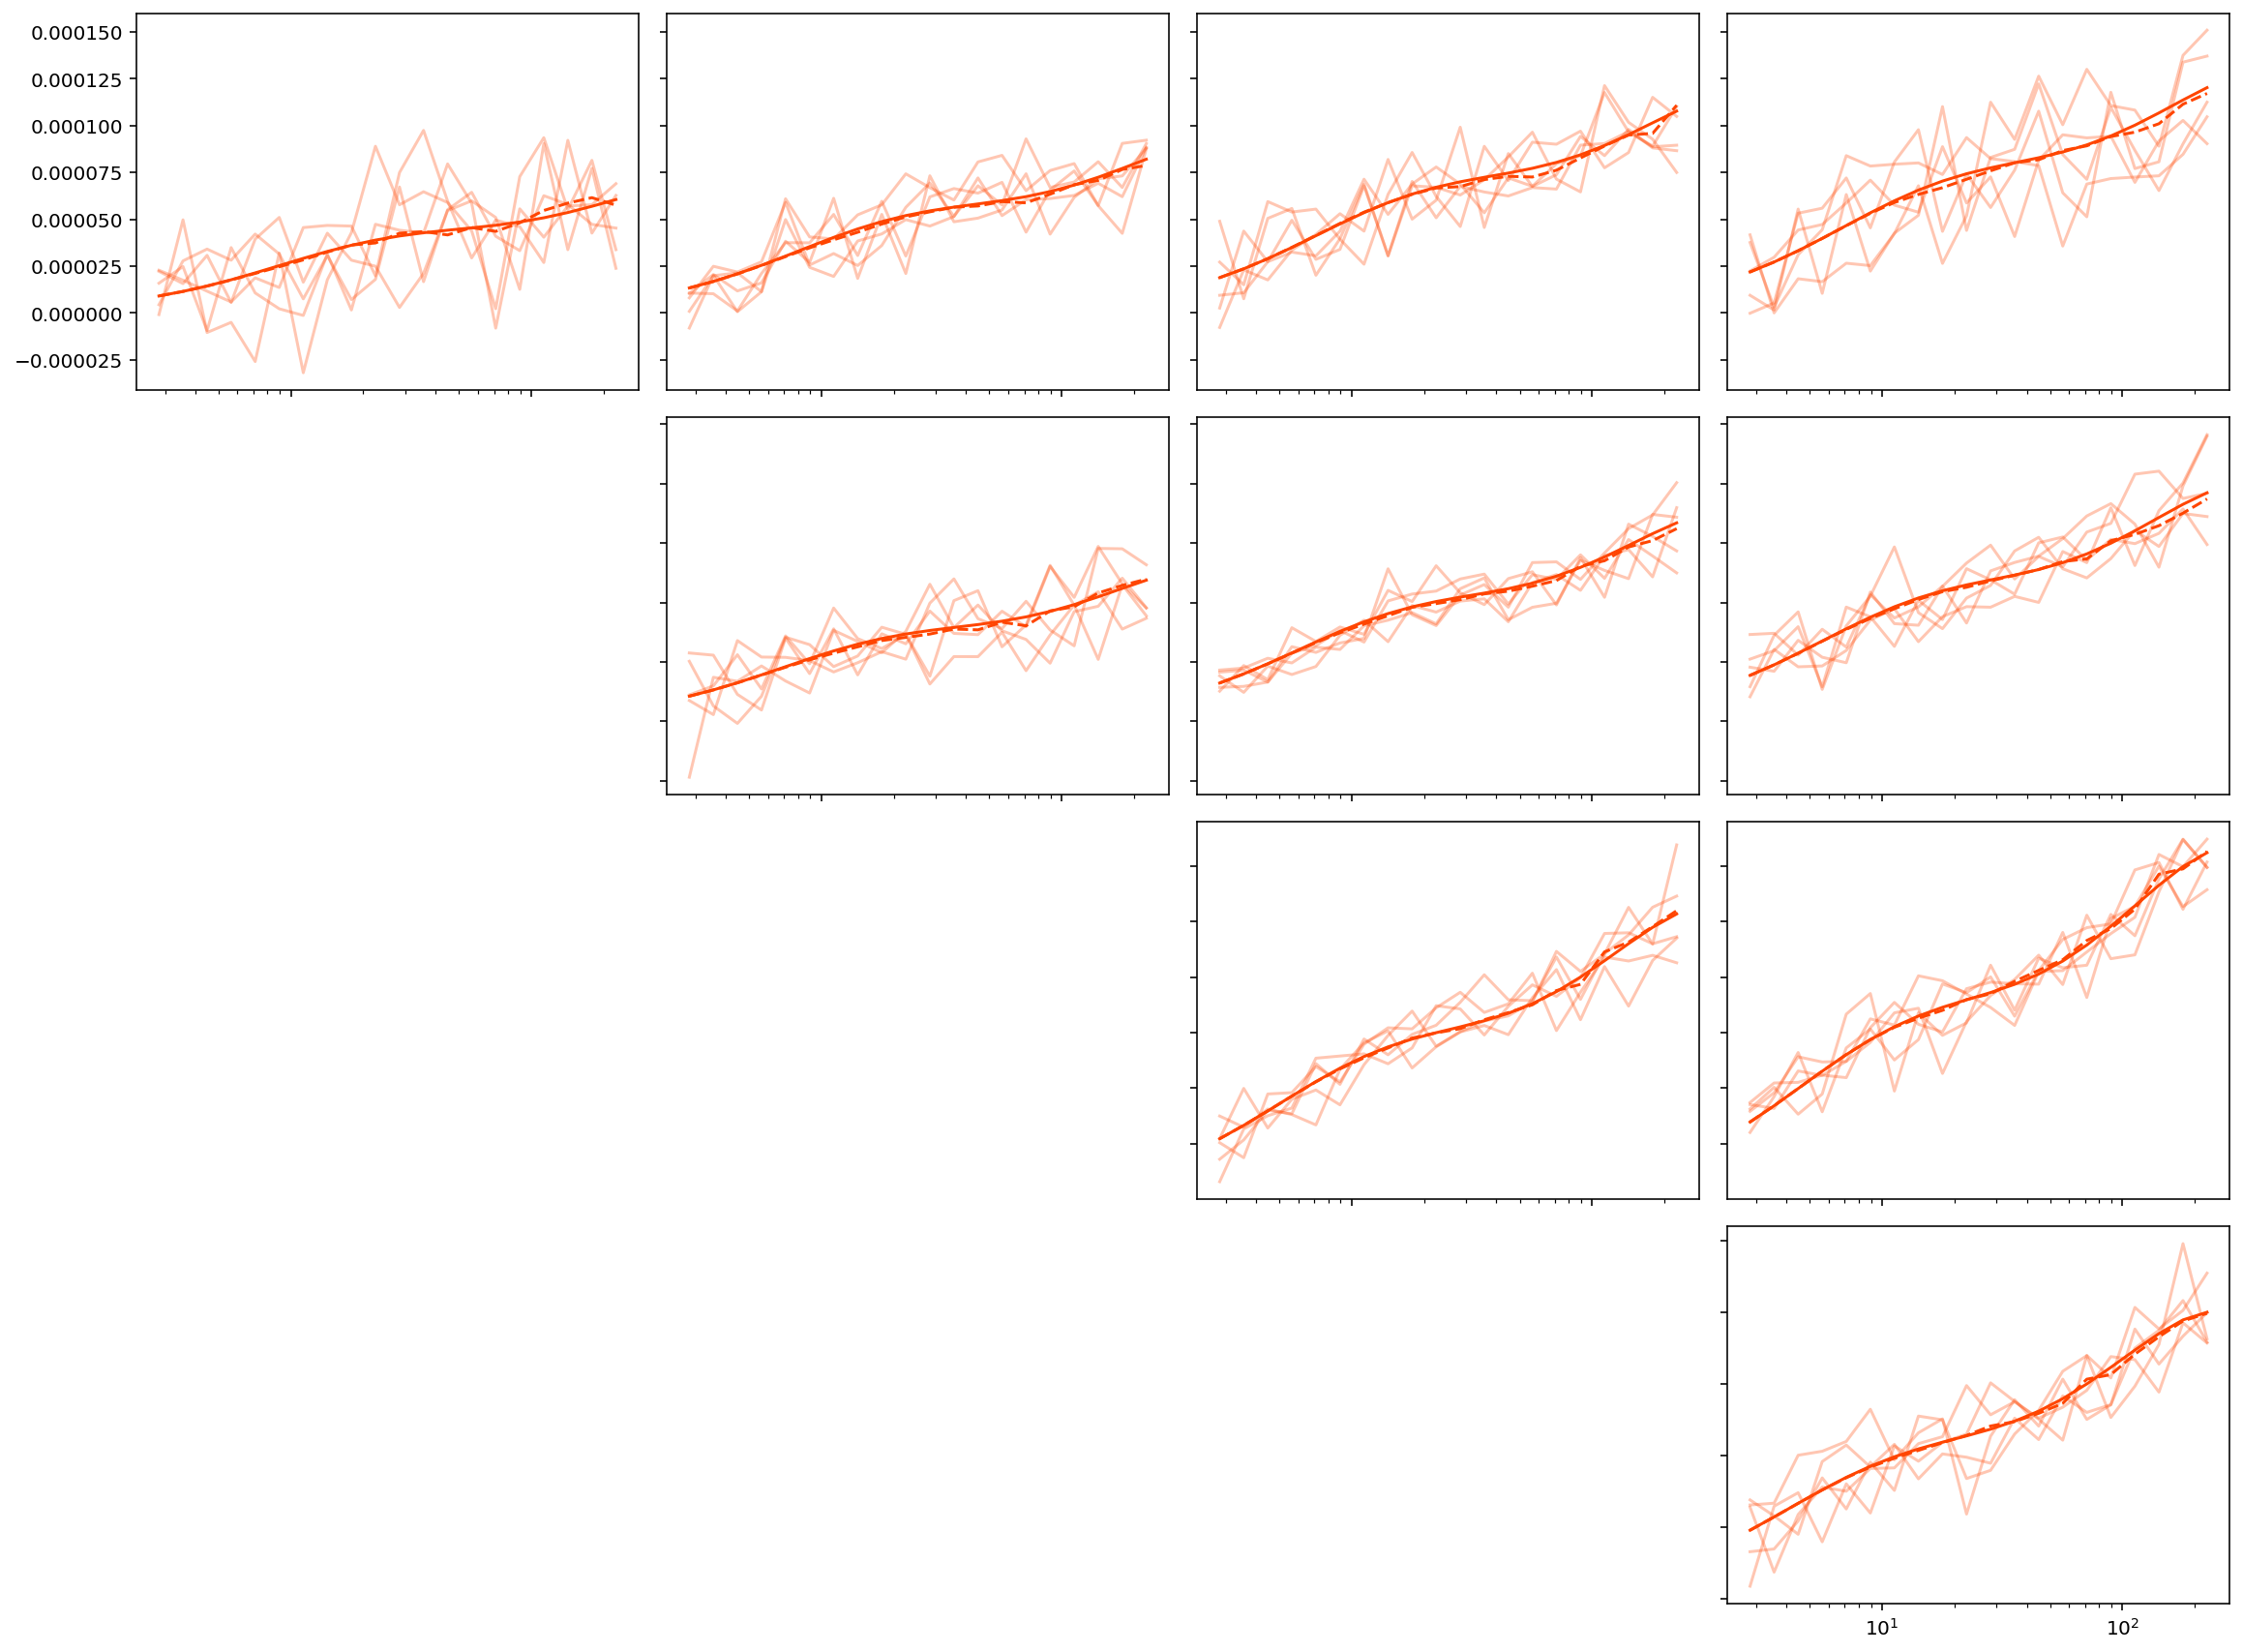

In [208]:
fig, axes = plt.subplots(4,4,figsize=(16,12), sharex=True, sharey='row')

tt = tp['xip'].data['ANG'][:20]

dist = conditional_multivariate_normal(mu, full_cov_BB_xipm, dv, np.arange(m_BB))

for i in range(4):
    for j in range(4):
        w = (tp['xip'].data['BIN1'] == i+1) & (tp['xip'].data['BIN2'] == j+1)
        ax = axes[i,j]
        if np.sum(w)>0:
            assert np.sum(w)==20
            ax.plot(tt, tt*mu_xipm_th[200:][w], c='orangered')
            ax.plot(tt, tt*dist.mean[200:][w], c='orangered', ls='--')
#             ax.plot(tt, tt*mu_xipm_th[200:][w])
            for _ in range(5):
                mu_xipm_BB = dist.rvs()
                ax.plot(tt, tt*mu_xipm_BB[200:][w], c='orangered', alpha=0.3)
#             ax.plot(tt, tt*mu_xipm_BB[200:][w])
            ax.set_xscale('log')
        else:
            ax.axis('off')

plt.tight_layout()